In [1]:
import sys
#sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

import pydot

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[50,50,50],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

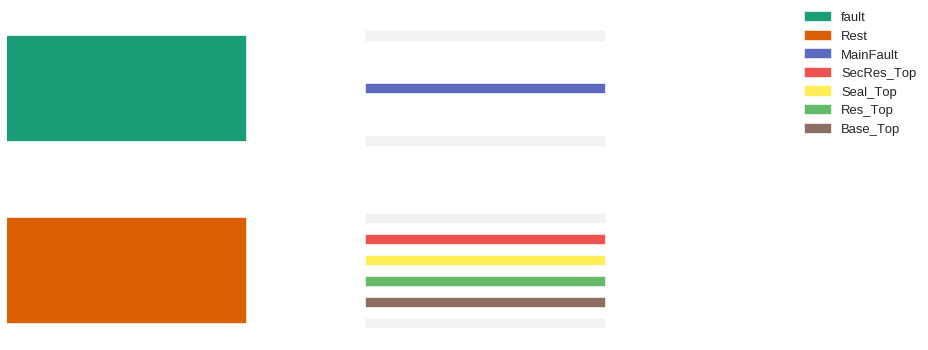

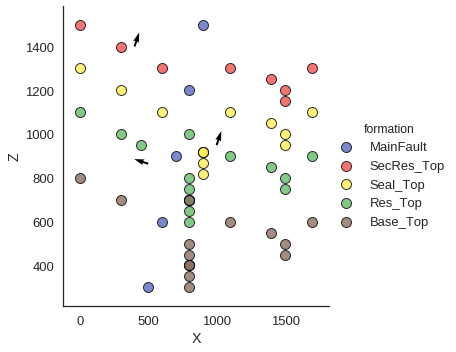

In [3]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

gp.plot_data(geo_data)

In [4]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

In [5]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


In [6]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [7]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [8]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))
#fault_surf, fault_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['MainFault']))

In [9]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=False
                   )

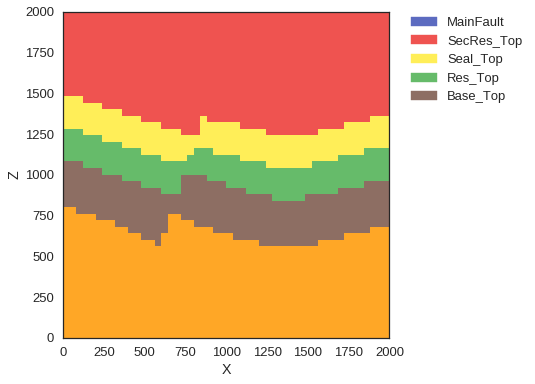

In [10]:
#%matplotlib notebook
%matplotlib inline
figsize(15,6)
gp.plot_section(geo_data, lith_sol[0], 25, plot_data=0)

In [11]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

In [12]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

    #@staticmethod # possibly use to find saddle points!
    #def squared_euclidean_distances(x_1, x_2):
    #    """
    #    Compute the euclidian distances in 3D between all the points in x_1 and x_2
    #    Args:
    #        x_1 (theano.tensor.matrix): shape n_points x number dimension
    #        x_2 (theano.tensor.matrix): shape n_points x number dimension
#
    #    Returns:
    #        theano.tensor.matrix: Distancse matrix. shape n_points x n_points
    #    """
#
    #    # T.maximum avoid negative numbers increasing stability
    #    sqd = T.sqrt(T.maximum(
    #        (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    #        (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    #        2 * x_1.dot(x_2.T), 0
    #    ))
#
    #    return sqd

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering - not used atm
    # supposed to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points    # substracting leak bool from saddle point bool 
                                                    # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    #if juxtaposition_over_seal(lith, fault) == True: #check for juxtaposition with layers above seal (due to offset)
    
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [13]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) # rounding up
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

def topo_analysis(lith, fault, fault_seal, seal_th):
    #fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
    gp.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in trap_keys:
        print('Checking Section:', tk)
        # Check for adjacency to model border
        if gp.topology_check_adjacency(G, tk, pad_keys[0]) == False:
            # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
            if juxta_SSF_check(G, tk, tot_over_keys, topo_block, seal_th) == True:
                traps.append(tk)
                print('TRAP:', tk)
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    return trap_mask # this mask returns True for all voxels which were accepted as trap voxels

In [14]:
def juxta_SSF_check(G, tk, tot_over_keys, topo_block, seal_th):
    trap_throw = 0
    jp=0
    for ok in tot_over_keys:  
        if gp.topology_check_adjacency(G, tk, ok) == True:
            print("Adjacency with section:", ok)
            if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
                print("Stratigraphic adjacency, leakage assumed!")
                return False                         # stratigraphic adjancency assumed to always leak
            elif G.adj[tk][ok]['edge_type'] == 'fault':
                # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
                print("Fault edge adjacency! Analyse shape.")
                section_throw = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[2]*scale_factor
                trap_throw += section_throw
                print("Adding %s to throw, over_section: %s" % (section_throw, ok))
                jp+=1
    if jp == 0:
        print('No JP with any layer over seal.')
        return True
    else:
        print('JP with layer over seal, checking SSF.')
        tot_fault_throw = trap_throw + seal_th
        SSF = tot_fault_throw/seal_th
        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
        if SSF > SSF_c:
            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
            return False
        else: 
            print('SSF ok, complete shale smear sealing assumed.')
            return True
            
# Shale Smear Factor SSF = Fault throw / Shale layer thickness
# SSF threshold = 7 --> incomplete shale smear to be expected for higher values
# SGR equivalent = 14%
# Shale Gouge Ratio SGR = (Sum(Shale bed thickness in throw)/Fault throw)*100%
# Attention: Need to count shale thickness into throw!
# From: Yielding et al. (1997)

In [15]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing, seal_th):
    
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        #print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        #print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            #print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            #leak_z = np.nan
            leak_z = 2000
        else:
            #print('Leak Point:',leak_point)
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])
        if fault_sealing == True:
            if max_z == spill_z:
                print("Spill point defines trap.")
                print("Fault is sealing. Down to spill.")
                #bottom_surface = spill_bottom
            else:
                print("Fault leak point above spill point.")
                max_z = spill_z
                print("...but fault sealing. Down to spill.")
                #bottom_surface = spill_bottom
        else:
            if max_z == spill_z:
                print("Spill point defines trap.")
                print("Fault is pathway. Down to spill.")
                #bottom_surface = spill_bottom
            else:
                print("Fault leak point above spill point.")
                print("Cross-fault leakage. Down to leak.")
                #bottom_surface = leak_bottom      
        
        #print('Max_Z:', max_z)
        res_nr = interp_data.get_formation_number()['Base_Top']
        res_nr_bool = lith == res_nr
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr_bool)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            return 0, lith, bottom_surface, pre_trap_mask
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
            final_trap_mask = topo_analysis(lith, fault, fault_sealing, seal_th)
            #lith[pre_trap_mask_bool] = 5
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            # revert to lith_block without any masks
            lith[pre_trap_mask_bool] = res_nr        
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask

In [16]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [17]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

#res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])    

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 30 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 75
#offset_unc = pymc.Normal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f))
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-4)

# FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [18]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

#interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',25)

In [19]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc
    
    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    
    print('Fault offset variation:', off_unc*rescale_f)
    #print('CHECK1:', new_z_res_top)
    #print('CHECK2:', HW_new_z_res_top)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, print_figures=False):
    print('Fault sealing =', fault_sealing)
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum reservoir volume: %s m³" % max_vol)
        #gp.plot_section(geo_data, lith_sol[0,0], 5, plot_data =1)
        #gp.plot_section(geo_data, lith_sol[0,0], 45, plot_data =1)
        if print_figures:
            gp.plot_section(geo_data, lith_sol[0], 25, plot_data =1)
            gp.plot_section(geo_data, trap, 25, plot_data =1)
        # revert lith_block back to formation numbers only (or can I include trap in plot?)
        
        return lith_sol, fault_sol, max_vol, trap
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = idh, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, G, topo_block, trap_keys, tot_over_keys = max_trap_vol(idh, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum reservoir volume: %s m³" % max_vol)
        return lith_sol, fault_sol, max_vol, trap
    
# Check juxtaposition area with layers above seal
@pymc.deterministic
def over_jux_area(lith_sol=structural_model[0], fault_sol=structural_model[1]):
    lith = lith_sol[0].reshape(50,50,50)
    fault = fault_sol[0].reshape(50,50,50)
    area = 0
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = \
    gp.topology_analyze(lith, fault, 1, areas_bool=True, return_block=False)
    res_nr = interp_data.get_formation_number()['Base_Top']
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    for rk in res_keys:
        for ok in tot_over_keys:
            if gp.topology_check_adjacency(G, rk, ok) == True:
                    if G.adj[rk][ok]['edge_type'] == 'fault':
                        part_area = G.adj[rk][ok]['area']*(scale_factor**2)
                        area += part_area
    return area       
                
# Avoid layer inversion by giving negative thicknesses a likelihood of zero
#@pymc.deterministic
#def no_inversion(sec_res_th=sec_res_th, res_th=res_th, seal_th=seal_th)

Z variations top to bottom: -10.0010392051 14.3042208798 -33.9431126978 -13.7258457982
Fault offset variation: -64.9439717859
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Serie

Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 10
Adjacency with section: 5
Fault edge adjacency! Analyse shape.
Unable to calculate an adjacency area.
Adding 0.0 to throw, over_section: 5
JP with layer over seal, checking SSF.
SSF = [248.24733357764353] / [248.24733357764353] = [1.0]
SSF ok, complete shale smear sealing assumed.
TRAP: 10
Maximum reservoir volume: 15168000.0 m³


In [20]:
iterations = 10

In [21]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [22]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

Z variations top to bottom: 12.1330183871 79.8628011917 -15.5123881423 -82.2081685991
Fault offset variation: -42.0748336411
Fault sealing = False


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:98: DeprecationWarning: numpy 

Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 13
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum reservoir volume: 20096000.0 m³
 [-------          20%                  ] 2 of 10 complete in 10.3 sec

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Z variations top to bottom: 26.6591108543 -92.1880102935 -116.844817198 37.0887533845
Fault offset variation: 18.8432519679
Fault sealing = False
Fault leak point above spill point.
Cross-fault leakage. Down to leak.
Checking Section: 13
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum reservoir volume: 8064000.0 m³
 [-----------      30%                  ] 3 of 10 complete in 20.4 secZ variations top to bottom: -39.4201461025 -42.7562979994 -21.1500769524 182.468269708
Fault offset variation: -52.2832650957
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 10
Adjacency with section: 5
Fault edge adjacency! Analyse shape.
Unable to calculate an adjacency area.
Adding 0.0 to throw, over_section: 5
JP with layer over seal, checking SSF.
SSF = [178.3937789529964] / [178.3937789529964] = [1.0]
SSF ok, complete shale smear sealing assumed.
TRAP: 10
Maximum reservoir volume: 15424000.0 m³
 [-----------

In [23]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume,[3]=trap_block
over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

max_volume_trace = structural_model_trace[:,2]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

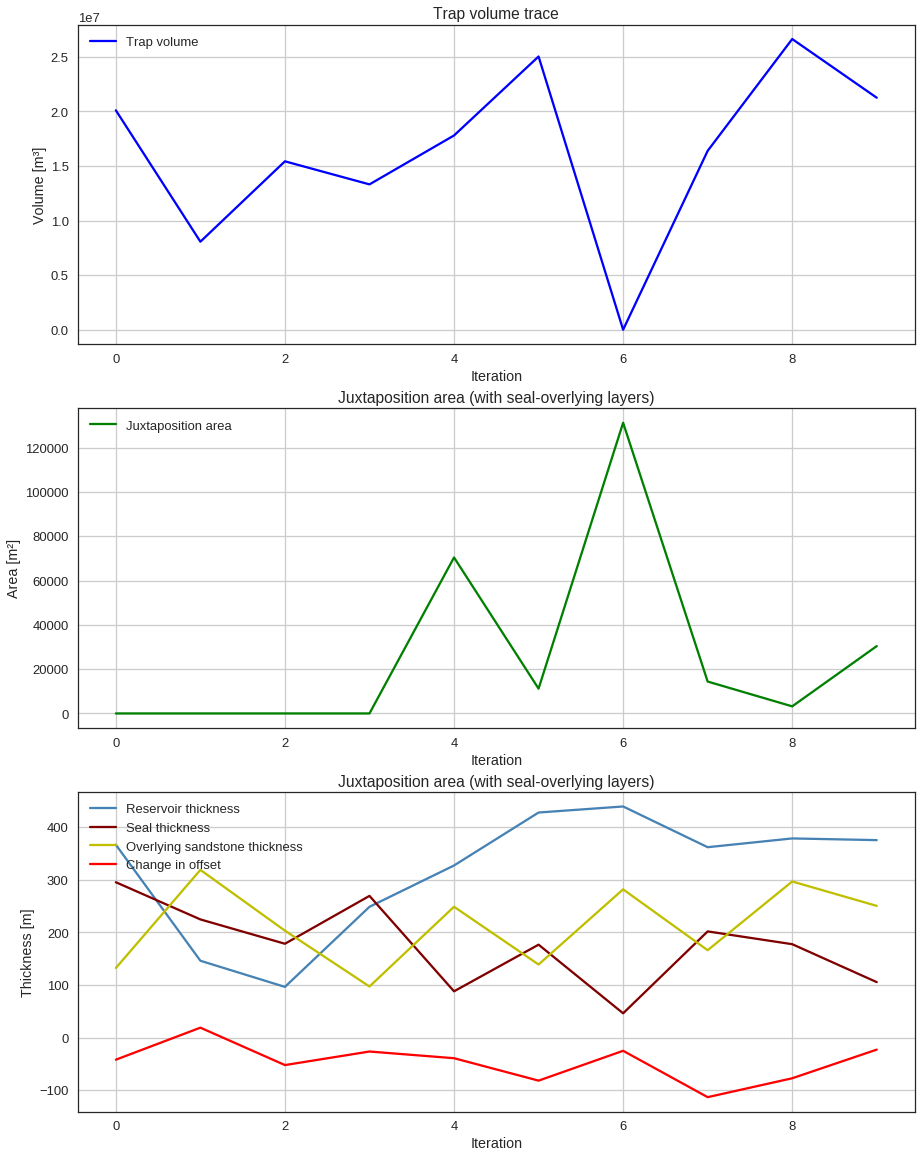

In [46]:
figsize(15,20)
fig, ax = plt.subplots(3, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
ax[1].set_title('Juxtaposition area (with seal-overlying layers)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Area [m²]')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

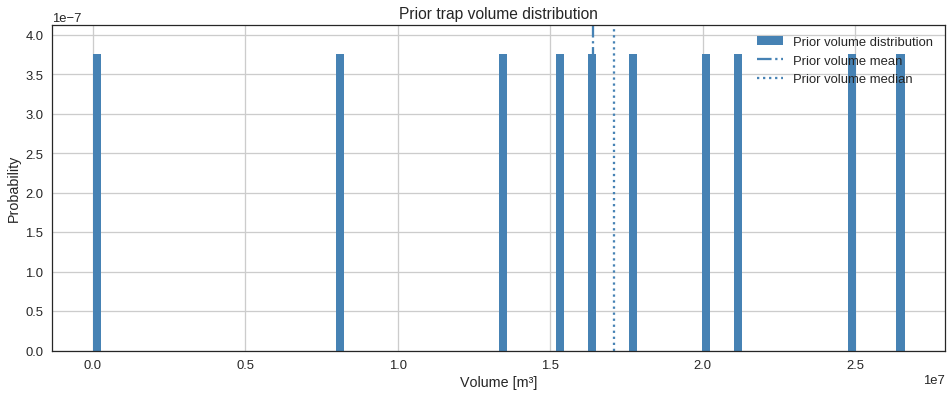

In [25]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [26]:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/21_10B-TRAP_25iterUNC_LIKELIHOOD_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/21_10B-LITH_25iterUNC_LIKELIHOOD_%s" % (counter))

In [27]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

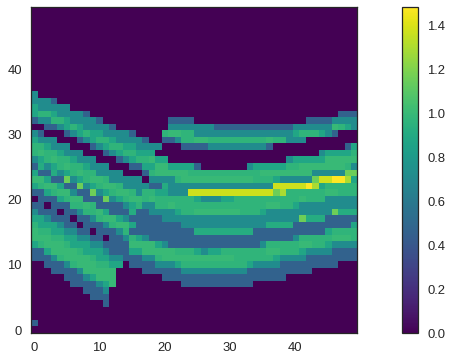

In [28]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0].astype(int))

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(50,50,50)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [29]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

Bayes action (minimum) at risk r 0.50: 17792000.00 --- expected loss: 5085600.00
Bayes action (minimum) at risk r 0.75: 16384000.00 --- expected loss: 6502000.00
Bayes action (minimum) at risk r 1.00: 16384000.00 --- expected loss: 7707200.00
Bayes action (minimum) at risk r 1.25: 15424000.00 --- expected loss: 8798400.00
Bayes action (minimum) at risk r 1.50: 15424000.00 --- expected loss: 9865600.00


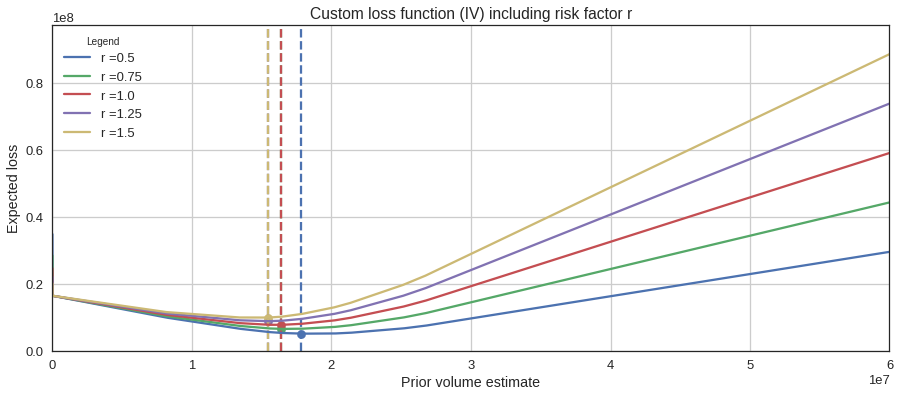

In [30]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Prior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

In [31]:
# THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 10
std2 = 20
std3 = 15

#@pymc.stochastic
#def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
#    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))
#
#@pymc.stochastic
#def seal_th_likelihood(value = 0, seal_th=seal_th):
#    return pymc.normal_like(seal_th, 400., 1./np.square(std2))
#
#@pymc.stochastic
#def res_th_likelihood(value = 0, res_th=res_th):
#    return pymc.normal_like(res_th, 250., 1./np.square(std3))

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 100., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 350., 1./np.square(std3))

In [32]:
# JUXTAPOSITION AREA LIKELIHOOD (not used)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [33]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, over_jux_area, 
                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [34]:
iterations=15

In [35]:
M_L = pymc.MCMC(model_L)
M_L.sample(iter=iterations, burn=5)

Z variations top to bottom: 76.7952644186 26.4097681495 120.991900914 45.5428657324
Fault offset variation: -30.3344684219
Z variations top to bottom: 92.2644934023 26.4097681495 120.991900914 45.5428657324
Fault offset variation: -30.3344684219
Z variations top to bottom: 76.7952644186 26.4097681495 

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:80: UserWarning: Boolean Serie

279.741858457 45.5428657324
Fault offset variation: -30.3344684219
Z variations top to bottom: 76.7952644186 26.4097681495 120.991900914 73.5276242366
Fault offset variation: -30.3344684219
Z variations top to bottom: 76.7952644186 7.66386769649 120.991900914 73.5276242366
Fault offset variation: -30.3344684219
Z variations top to bottom: 76.7952644186 26.4097681495 120.991900914 73.5276242366
Fault offset variation: -20.0779131736
Z variations top to bottom: 146.58676462 26.4097681495 120.991900914 73.5276242366
Fault offset variation: -20.0779131736
Z variations top to bottom: 76.7952644186 26.4097681495 40.3442761115 73.5276242366
Fault offset variation: -20.0779131736
Z variations top to bottom: 76.7952644186 26.4097681495 120.991900914 19.9336489956
Fault offset variation: -20.0779131736
Z variations top to bottom: 76.7952644186 34.1214505601 120.991900914 73.5276242366
Fault offset variation: -20.0779131736
 [-------          20%                  ] 3 of 15 complete in 0.7 secZ va

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 13
Checking Section: 10
Adjacency with section: 5
Fault edge adjacency! Analyse shape.
Unable to calculate an adjacency area.
Adding 0.0 to throw, over_section: 5
JP with layer over seal, checking SSF.
SSF = [191.01499597103248] / [191.01499597103248] = [1.0]
SSF ok, complete shale smear sealing assumed.
TRAP: 10
Maximum reservoir volume: 20800000.0 m³
 [-----------------46%                  ] 7 of 15 complete in 12.1 secZ variations top to bottom: 76.7952644186 112.006896886 120.991900914 66.6632626691
Fault offset variation: -111.935507131
Z variations top to bottom: -4.72450502803 112.006896886 120.991900914 66.6632626691
Fault offset variation: -111.935507131
Z variations top to bottom: 76.7952644186 112.006896886 102.377122445 66.6632626691
Fault offset variation: -111.935507131
Z variations top to bottom: 76.7952644186 112.006896886 120.991900914 39.2947249292
Fault offset variation: -111.935507131
Z var

 [-----------------86%------------      ] 13 of 15 complete in 75.6 secZ variations top to bottom: 63.141839308 115.139799276 172.132780268 152.185006175
Fault offset variation: -161.616236603
Z variations top to bottom: 33.1197789475 115.139799276 172.132780268 152.185006175
Fault offset variation: -147.965697767
Z variations top to bottom: 63.141839308 115.139799276 333.738480997 152.185006175
Fault offset variation: -147.965697767
Z variations top to bottom: 63.141839308 115.139799276 172.132780268 227.785165572
Fault offset variation: -147.965697767
Z variations top to bottom: 63.141839308 130.701644754 172.132780268 152.185006175
Fault offset variation: -147.965697767
Z variations top to bottom: 63.141839308 115.139799276 172.132780268 152.185006175
Fault offset variation: -147.965697767
Fault sealing = False
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 11
Adjacency with section: 5
Fault edge adjacency! Analyse shape.
(array([19, 19, 19, 19, 19, 19,

In [36]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume
over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]
max_volume_trace_L = structural_model_trace_L[:,2]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

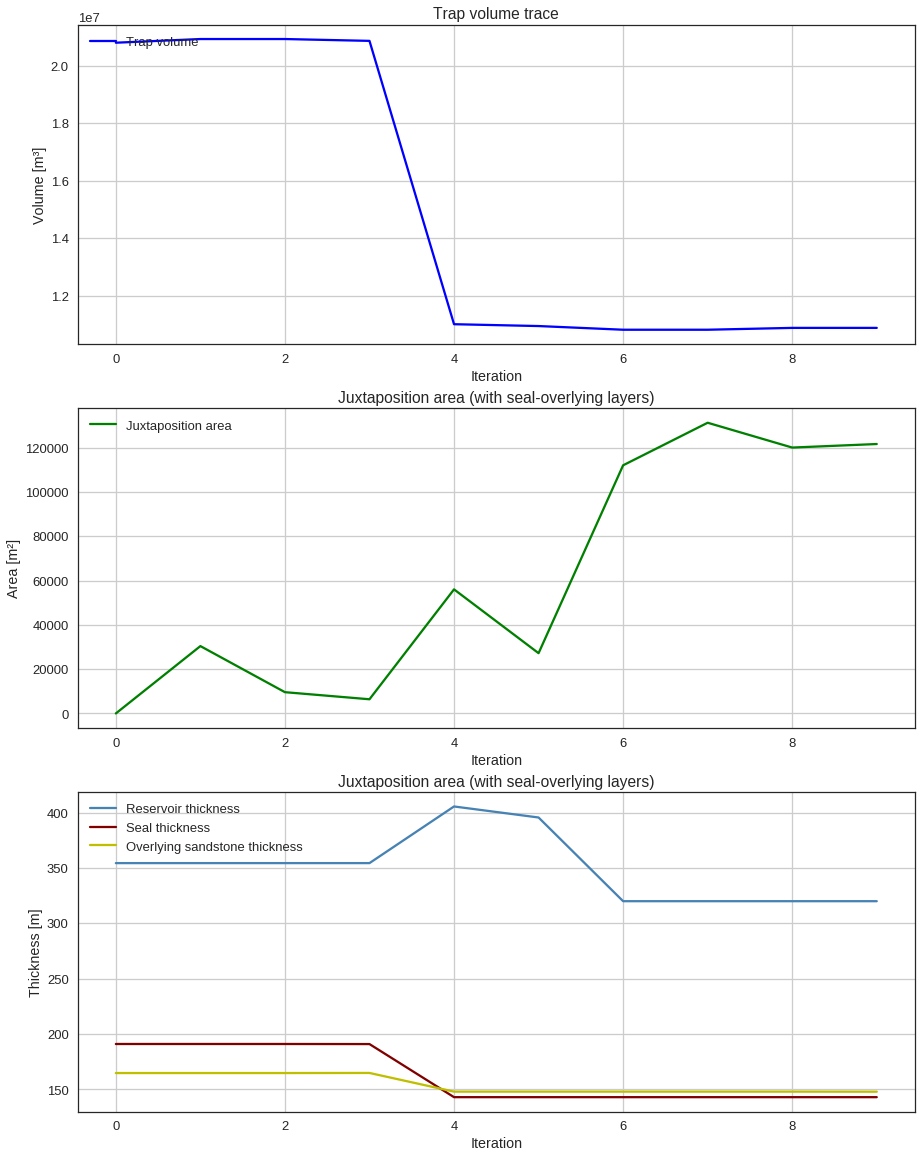

In [37]:
figsize(15,20)
fig, ax = plt.subplots(3, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
ax[1].set_title('Juxtaposition area (with seal-overlying layers)')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Area [m²]')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

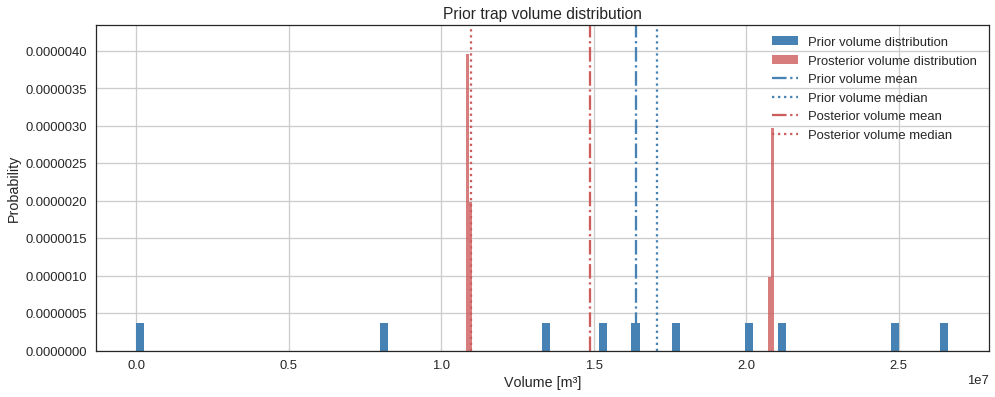

In [38]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
_hist2 = plt.hist(max_volume_trace_L, bins=100, normed=True, 
                  histtype="stepfilled",label="Prosterior volume distribution", color="indianred", alpha = 0.8)
_hist_scale = np.append(_hist1[0],_hist2[0])
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist_scale), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist_scale), label="Prior volume median", linestyles=":", color = "steelblue")
plt.vlines(max_volume_trace_L.mean(), 0, 1.1 * np.max(_hist_scale), label="Posterior volume mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(max_volume_trace_L), 0, 1.1 * np.max(_hist_scale), label="Posterior volume median", linestyles=":", color = "indianred")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist_scale)+1, np.max(_hist_scale)/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist_scale))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

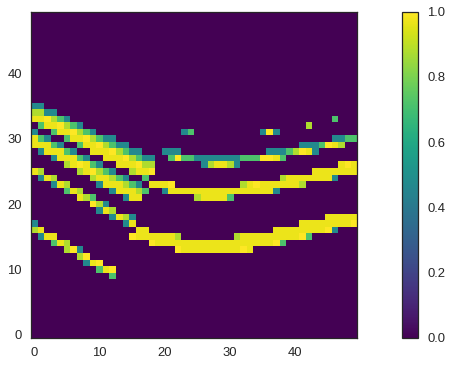

In [39]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(50,50,50)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

Bayes action (minimum) at risk r 0.50: 20800000.00 --- expected loss: 3748000.00
Bayes action (minimum) at risk r 0.75: 11008000.00 --- expected loss: 4014800.00
Bayes action (minimum) at risk r 1.00: 10944000.00 --- expected loss: 4028800.00
Bayes action (minimum) at risk r 1.25: 10880000.00 --- expected loss: 4039200.00
Bayes action (minimum) at risk r 1.50: 10880000.00 --- expected loss: 4043200.00


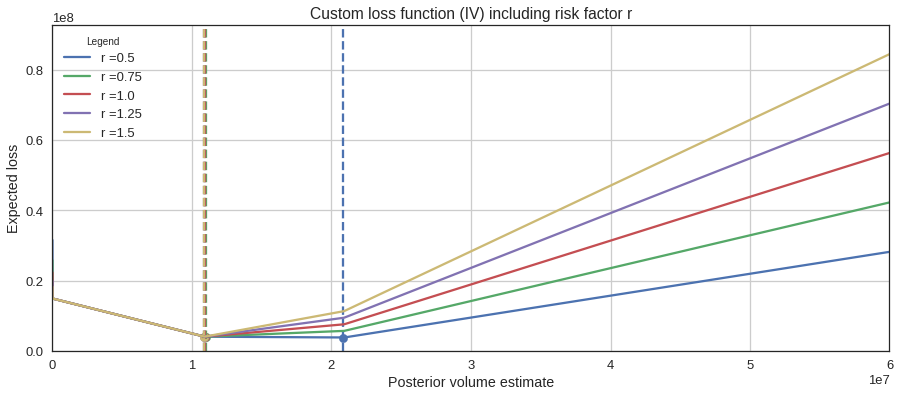

In [40]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Posterior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()


In [38]:
import graphviz
pymc.graph.dag(model)

In [65]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
graph = pymc.graph.graph(model)
graph.write_png()

SyntaxError: invalid syntax (<ipython-input-65-5c4e5ea505c4>, line 3)

In [41]:
#figsize(16, 9)
#
## No reduced uncertainty, different risks
#BA_before = np.zeros_like(risks_s)
#EL_before = np.zeros_like(risks_s)
#expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()
#
#counter = 0
#for r in risks_s:
#    loss = [expected_loss(e, r) for e in estimates_s]
#    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
#    #print(_min_score)
#    if _min_score < 0:
#        _min_score = 0
#    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
#    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
#    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
#    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
#    BA_before[counter] = _min_score
#    EL_before[counter] = expected_loss(_min_score,r)
#    counter += 1
#

In [42]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [43]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)